# Homework 6

In this homework you will be training and using a "char-RNN". This is the name given to a character-level recurrent neural network language model by [this famous blog post by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Before you start on the rest of the homework, please give the blog post a read, it's quite good!

I don't expect you to implement the char-RNN from scratch. Andrej's original char-rnn is in Torch (the predecessor to PyTorch that is not commonly used anymore). Fortunately, there are many other implementations of this model available; for example, there is one (in both mxnet and pytorch) in chapters 8 and 9 of [the textbook](http://d2l.ai), and another pytorch one [here](https://github.com/spro/char-rnn.pytorch). **Please use one of these example implementations (or another one that you find) when completing this homework**.

For this homework, please complete the following steps:

1. Download and tokenize the [Shakespeare dataset](http://www.gutenberg.org/files/100/100-0.txt) at a character level. I recommend basing your solution on the following code:
```Python
# Remove non-alphabetical characters, lowercase, and replace whitespace with ' '
raw_dataset = ' '.join(re.sub('[^A-Za-z]+','', text).lower().split())
# Maps token index to character
idx_to_char = list(set(raw_dataset))
# Maps character to token index
char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
# Tokenize the dataset
corpus_indices = [char_to_idx[char] for char in raw_dataset]
```
1. Train a "vanilla" RNN (as described in chapter 8 of [the textbook](http://d2l.ai)) on the Shakespeare dataset. Report the training loss and generate some samples from the model at the end of training.
1. Train a GRU RNN (as described in chapter 9 of [the textbook](http://d2l.ai)) on the Shakespeare datatset. Is the final training loss higher or lower than the vanilla RNN? Are the samples from the model more or less realistic?
1. Find a smaller, simpler dataset than the Shakespeare data (you can find some ideas in Andrej's blog post, but feel free to get creative!) and train either the vanilla or GRU RNN on it instead. Is the final training loss higher or lower than it was for the Shakespeare data?

# #1 Dataset

In [25]:
!pip install -q tqdm
from tqdm import tqdm

In [26]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.transforms as transforms
from IPython import display
import time
from string import ascii_lowercase
from string import ascii_uppercase

In [27]:
use_cuda = False

In [28]:
import requests
import string
import random

all_characters = string.printable
n_characters = len(all_characters)

def DownloadFile(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url)
    return r.text

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor  

def random_training_set(chunk_len, batch_size, file):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, len(file) - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if use_cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
  
target_url = "https://raw.githubusercontent.com/cos495/code/master/shakespeare.txt"
data = DownloadFile(target_url)
#print(random_training_set(10, 8, data))
print(data[10:100])

zen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


# #2 Vanilla RNN

In [29]:
# https://github.com/spro/char-rnn.pytorch
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="rnn", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        if model=="lstm":
          self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        if model=="gru":
          self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
          
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)       
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

###Initialize Model

In [30]:
hidden_size = 100
learning_rate = 0.01
cell = "rnn"
n_layers = 2

decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=cell,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

if use_cuda:
    decoder.cuda()

In [31]:
n_epochs = 2000
chunk_len = 200
print_every = 100
batch_size = 100

In [32]:
def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if use_cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    #Old version (doesn't support zero indexing)
    #return loss.data[0] / chunk_len
    return loss.data / chunk_len

###Generate Text

In [33]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

In [34]:
start = time.time()
all_losses = []
loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set(chunk_len, batch_size, data))
    loss_avg += loss
    all_losses.append(loss.item())
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print('loss: ', loss)
        print(generate(decoder, 'Wh', 100, cuda=use_cuda), '\n')

  0%|          | 0/2000 [00:00<?, ?it/s]

Training for 2000 epochs...


  5%|▌         | 100/2000 [00:42<13:56,  2.27it/s]

 42s (100 5%) 1.8123]
loss:  tensor(1.8123)
Where priath and nrield did
Of in'le your grown hother thy hear not are dulse to I with thle
I his don 



 10%|█         | 200/2000 [01:25<13:05,  2.29it/s]

 25s (200 10%) 1.6499]
loss:  tensor(1.6499)
Why heart, sir he reack and look;
The would where a deather ears and deverdst theal.

CORIOLANUS:
Ay h 



 15%|█▌        | 300/2000 [02:08<12:21,  2.29it/s]

 8s (300 15%) 1.5875]
loss:  tensor(1.5875)
Whost and stands it rave thought thou have now, I standing better the knovendering by tilloust shall c 



 20%|██        | 400/2000 [02:51<11:49,  2.26it/s]

 50s (400 20%) 1.5427]
loss:  tensor(1.5427)
Whose not say, methou the day fear the brink, for that should on the laper thou guetion:
Yet this come 



 25%|██▌       | 500/2000 [03:33<11:02,  2.26it/s]

 33s (500 25%) 1.4994]
loss:  tensor(1.4994)
When bead;
If you speak, they hath some shund the be he leavens to dome his hards made that so fancent 



 30%|███       | 600/2000 [04:16<10:07,  2.30it/s]

 16s (600 30%) 1.5446]
loss:  tensor(1.5446)
Where the sorrow your mart with that we shall would speak, and this good unchard, as our day,
see hait 



 35%|███▌      | 700/2000 [04:58<09:19,  2.32it/s]

 58s (700 35%) 1.5057]
loss:  tensor(1.5057)
Which sin; it would ever blown of her smiler madred men one till supplicing,
That shall nays,
Plear of 



 40%|████      | 800/2000 [05:40<08:36,  2.32it/s]

 40s (800 40%) 1.4852]
loss:  tensor(1.4852)
Which none inteing friend,
And hence, in you, married?

ROMEO:
Go there hang thou wish, when thou she  



 45%|████▌     | 900/2000 [06:22<07:57,  2.30it/s]

 22s (900 45%) 1.4988]
loss:  tensor(1.4988)
Which I know, empoor may did not shall never with was no forget in your grief;
And not come my body: a 



 50%|█████     | 1000/2000 [07:05<07:12,  2.31it/s]

 5s (1000 50%) 1.4949]
loss:  tensor(1.4949)
Whilst some sons the love
Is you and africe,
Where was this to this be curst thou follow is favours:
C 



 55%|█████▌    | 1100/2000 [07:47<06:28,  2.32it/s]

 47s (1100 55%) 1.4868]
loss:  tensor(1.4868)
Where mark him.

ISABELLA:
Convers with the watch, wounds good want, for your wor help but honesty.

J 



 60%|██████    | 1200/2000 [08:30<05:49,  2.29it/s]

 30s (1200 60%) 1.4949]
loss:  tensor(1.4949)
What to your vuilla! one sun the desire in protors! and excenders
beseech and to my son.

GLOUCESTER:
 



 65%|██████▌   | 1300/2000 [09:13<04:59,  2.34it/s]

 12s (1300 65%) 1.4807]
loss:  tensor(1.4807)
Where with dishmas for me, what thou hath my well:
Laids.

PRINCENTE:
What is a bid that go thee weddo 



 70%|███████   | 1400/2000 [09:55<04:19,  2.31it/s]

 55s (1400 70%) 1.4247]
loss:  tensor(1.4247)
Where is the preparela, and my contrame forite whom in and of scove, sir.

LUCENTIO:
Who you seed.

CO 



 75%|███████▌  | 1500/2000 [10:38<03:42,  2.25it/s]

 38s (1500 75%) 1.4568]
loss:  tensor(1.4568)
Where was both's son, with
so lame.

CLAUDIO:
Why do this women a loss to the brother's person; but to 



 80%|████████  | 1600/2000 [11:20<02:54,  2.29it/s]

 20s (1600 80%) 1.4682]
loss:  tensor(1.4682)
Whom here
wast sads use I should in the just themsious sight!

YORK:
It is my slaughter, when me to sa 



 85%|████████▌ | 1700/2000 [12:03<02:12,  2.26it/s]

 3s (1700 85%) 1.4761]
loss:  tensor(1.4761)
Whose our conselved unclews, stands as gather tack to term'd upon the basing of mine sadnted the other 



 90%|█████████ | 1800/2000 [12:46<01:27,  2.29it/s]

 46s (1800 90%) 1.4941]
loss:  tensor(1.4941)
When these the great blow a hungrows can my house the prest
Being set your souls be another in Kate at 



 95%|█████████▌| 1900/2000 [13:29<00:44,  2.26it/s]

 29s (1900 95%) 1.4321]
loss:  tensor(1.4321)
What you contempt,
Whilst you many and will not grace you in,
break, from his complain,
Make open to m 



100%|██████████| 2000/2000 [14:12<00:00,  2.35it/s]

 12s (2000 100%) 1.4686]
loss:  tensor(1.4686)
Where me
The corn with him my good
Cans and lapt, Jedue dost prison, still thus? like a cept's last an 



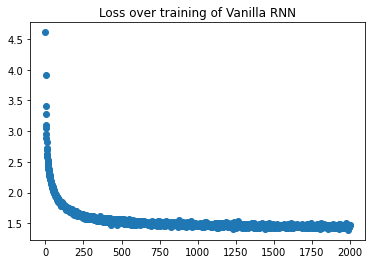

In [35]:
#Graph of Loss over t
x = range(len(all_losses))
plt.title("Loss over training of Vanilla RNN")
plt.scatter(x, all_losses)

###Smapling with high temperature

In [36]:
generate(decoder, prime_str="A", temperature= 100, cuda=use_cuda)

'A!\r}4?qdaZkzp;ZNb$f#gG7\nA]pZh\tM0C.tKXY;\t[\x0bU%/ +1S)m6M\x0bm8UEn\t-cjC"OL ]Q3S4v7h^MgjR,s=Lv%K0VHTCs\n_kc0G9'

###Sampling with low temperature

In [37]:
generate(decoder, prime_str="A", temperature= 1, cuda=use_cuda)
#Note the \n is a new line

"And that I'll I rensers fiolass world.\n\nBENVOLIO:\nGo word in degrace,\nNot come, up no dear\nHer straig"

###Samples generated for lowercase and uppercase alphabet for Vanilla RNN

In [38]:
for c in ascii_lowercase:
  print("GENERATED SAMPLE FOR: "+c)
  print(generate(decoder, c, 100, cuda=use_cuda), '\n')

for c in ascii_uppercase:
  print("GENERATED SAMPLE FOR: "+c)
  print(generate(decoder, c, 100, cuda=use_cuda), '\n')

GENERATED SAMPLE FOR: a
at.

CAMILLO:
Come
A forgiverona to me 'band, my lord and tears,
To makes am you are not ange to him  

GENERATED SAMPLE FOR: b
bere more art uneadenharn while of plantious majesty bearfue,
He in borne you bears to me, and I thin 

GENERATED SAMPLE FOR: c
compey.

GREGORELHAS:
Where hath brow, wherein the wine'st be deadly thee, my brother, my liege,
And  

GENERATED SAMPLE FOR: d
d of ask and one but vilves,
The tudgranted no, my foul on brout sooth to the world so sicken that wh 

GENERATED SAMPLE FOR: e
e wrong must here's not men, it rims.

CORIOLANUS:
My man; good merry-reauty
you make my brother's na 

GENERATED SAMPLE FOR: f
fandity.

MENENIUS:
Now to hearts
and her so? A duke, and thou hast, whose regot I have leave before  

GENERATED SAMPLE FOR: g
g?
Ay,
Speak out on home waking Marcius! less my dearly of Exgetuleets to power's chance it let that  

GENERATED SAMPLE FOR: h
here, but he now,
The commands remain strong and fortune the dash them my liege;

# #3 GRU RNN

###Initialize Model

In [39]:
hidden_size = 100
learning_rate = 0.01
cell = "gru"
n_layers = 2

decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=cell,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

if use_cuda:
    decoder.cuda()

In [40]:
n_epochs = 2000
chunk_len = 200
print_every = 100
batch_size = 100

In [41]:
def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if use_cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    #Old version (doesn't support zero indexing)
    #return loss.data[0] / chunk_len
    return loss.data / chunk_len

###Train GRU:

In [42]:
start = time.time()
all_losses = []
loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set(chunk_len, batch_size, data))
    loss_avg += loss
    all_losses.append(loss.item())
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print('loss: ', loss)
        print(generate(decoder, 'Wh', 100, cuda=use_cuda), '\n')

  0%|          | 0/2000 [00:00<?, ?it/s]

Training for 2000 epochs...


  5%|▌         | 100/2000 [01:13<23:31,  1.35it/s]

 13s (100 5%) 1.7684]
loss:  tensor(1.7684)
Whe post:
Or afceagay for the truck to good yor him to therefore I hands cany your stell and with tere 



 10%|█         | 200/2000 [02:26<22:04,  1.36it/s]

 26s (200 10%) 1.5859]
loss:  tensor(1.5859)
Wherer, and last thine
A the worls of him, and in then came eyes of bosily
They and plaintent three.

 



 15%|█▌        | 300/2000 [03:39<20:49,  1.36it/s]

 39s (300 15%) 1.5212]
loss:  tensor(1.5212)
Where beriend seeter.

PETRUCHIO:
I cunsel'd the blood ours' two no time.

QUEEN ELIZABETH:
O dempting 



 20%|██        | 400/2000 [04:51<19:53,  1.34it/s]

 51s (400 20%) 1.4770]
loss:  tensor(1.4770)
Whus your hand, time of prayers with he's a right
As lords, no all, my noble habfins?

All:
How please 



 25%|██▌       | 500/2000 [06:03<18:28,  1.35it/s]

 3s (500 25%) 1.4501]
loss:  tensor(1.4501)
Whemen hold with him to had us:
Come them too mean are the prince, but the sorrow?
What so me leave up 



 30%|███       | 600/2000 [07:15<16:58,  1.37it/s]

 15s (600 30%) 1.4219]
loss:  tensor(1.4219)
Wheast thou art common me him
Shall breathe and lords contend to deques back?

LADY ANNE:
But for I st 



 35%|███▌      | 700/2000 [08:27<15:59,  1.36it/s]

 27s (700 35%) 1.4081]
loss:  tensor(1.4081)
Whis merry then suster of you,
Thou sings their country to heaves, dark wail the crown
Is supprily hat 



 40%|████      | 800/2000 [09:38<14:33,  1.37it/s]

 38s (800 40%) 1.4216]
loss:  tensor(1.4216)
Wherefled under it. He have should York;
And to the rest stirry of villain,
And begin it false. Well,  



 45%|████▌     | 900/2000 [10:49<13:15,  1.38it/s]

 49s (900 45%) 1.3827]
loss:  tensor(1.3827)
Whomally said a said leave?

ESCALUS:
Why, he cannot I know the bawd.

HORTENSIO:
Sir, begreil to merc 



 50%|█████     | 1000/2000 [12:01<11:57,  1.39it/s]

 0s (1000 50%) 1.3741]
loss:  tensor(1.3741)
Wher, that I lord, that I cannot can love;
And grings are themselves, with me, badly be half.

QUEEN:
 



 55%|█████▌    | 1100/2000 [13:12<10:51,  1.38it/s]

 12s (1100 55%) 1.3711]
loss:  tensor(1.3711)
Why, sir, and Lord Hasting and beggar.

DUKE VINCENTIO:
You have foull so our field?

KING RICHARD III 



 60%|██████    | 1200/2000 [14:23<09:34,  1.39it/s]

 23s (1200 60%) 1.3675]
loss:  tensor(1.3675)
Whee this,? Woud,
My ground and trudge a Buckingham, go him, though poor I lits.

ROMEO:
And I, are yo 



 65%|██████▌   | 1300/2000 [15:34<08:28,  1.38it/s]

 34s (1300 65%) 1.3915]
loss:  tensor(1.3915)
Whee my master's land, ado?

MERCUTIO:
Come men my disgreak above my good stoo
at hand of shall serve  



 70%|███████   | 1400/2000 [16:45<07:18,  1.37it/s]

 45s (1400 70%) 1.3810]
loss:  tensor(1.3810)
Whom confesses the deep of heart?

First I have:
For bitter than your night with his worn I be no more 



 75%|███████▌  | 1500/2000 [17:56<05:58,  1.39it/s]

 56s (1500 75%) 1.3739]
loss:  tensor(1.3739)
What's have been?

AUFIDIUS:
I do the satisf.

ANGELO:
A blows out stay at me to this goodling.
Now ba 



 80%|████████  | 1600/2000 [19:07<04:50,  1.37it/s]

 7s (1600 80%) 1.3738]
loss:  tensor(1.3738)
What curst his parted but in common shall be
signity on the friend. Let their will fall morribut
I say 



 85%|████████▌ | 1700/2000 [20:18<03:34,  1.40it/s]

 18s (1700 85%) 1.3849]
loss:  tensor(1.3849)
What much invoterable study?

OXFORD:
These uncle hier days of me, I do pray thee;
Yet me.

GREMIO:
I  



 90%|█████████ | 1800/2000 [21:28<02:30,  1.33it/s]

 28s (1800 90%) 1.3596]
loss:  tensor(1.3596)
Which they they comes the view,
If thou art to certain of sufferess twenty taper-
Of to those night in 



 95%|█████████▌| 1900/2000 [22:37<01:09,  1.43it/s]

 37s (1900 95%) 1.3768]
loss:  tensor(1.3768)
Which so stain'd to the adprines:
I enjoin'd.

Clown:
You have the as at a treasons unfortune;
Thou wi 



100%|██████████| 2000/2000 [23:47<00:00,  1.40it/s]

 47s (2000 100%) 1.3388]
loss:  tensor(1.3388)
When storm'd him he's cup of ever
That he done by his folery is,
What left what thou that thought may  



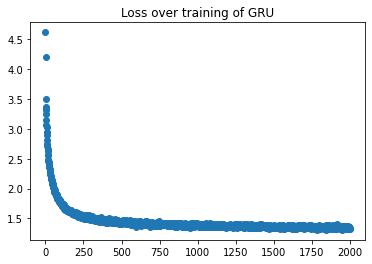

In [43]:
#Graph of Loss over t
x = range(len(all_losses))
plt.title("Loss over training of GRU")
plt.scatter(x, all_losses)

###Samples generated for lowercase and uppercase alphabet

In [44]:
for c in ascii_lowercase:
  print("GENERATED SAMPLE FOR: "+c)
  print(generate(decoder, c, 100, cuda=use_cuda), '\n')

for c in ascii_uppercase:
  print("GENERATED SAMPLE FOR: "+c)
  print(generate(decoder, c, 100, cuda=use_cuda), '\n')

GENERATED SAMPLE FOR: a
ard and speak.

Lord MOTwithinss and be stain,
Looket the great cousin with thy goodly town;
Why, the 

GENERATED SAMPLE FOR: b
bling, nor their head thee:
The dading more nothing of poor, and shall be sign of
Of this days and sh 

GENERATED SAMPLE FOR: c
cries to the calms,
Which we'll be beak the way, being homely
At the good will not his common'd to th 

GENERATED SAMPLE FOR: d
d where that thy wife.

HORTENSIO:
And let the honour is your horse?
Tell thee, and dissomention's bl 

GENERATED SAMPLE FOR: e
e I did be beak, for her kindly
As an own stirrance would was to the varlet
Upon, in thine old in the 

GENERATED SAMPLE FOR: f
fector, it streets are begn
To prove your head so devised.
He am I am turn'd, with the good Laurence, 

GENERATED SAMPLE FOR: g
g kindrate thee thy vile.

HASTINGS:
Thy sumber the death should be a led before when there
Or now la 

GENERATED SAMPLE FOR: h
hy like prince, whence of his for.

WARWICK:
Commish, along, Lewis with him!

MI

# #3.5 Comparision between Vanilla RNN and GRU RNN on Shakespeare Dataset
- Loss was lower for the GRU (~1.3 for GRU vs. ~1.4 for RNN)
- In my opinon, the samples generated by the GRU were better than the ones generated by the Vanilla RNN. The GRU samples seemed to have a better usage of punctuation, capital vs. lower case letters and realistic word length. Also, I personally thought the GRU had somewhat better grammar than the vanilla RNN (even though some of the words were made up).

# #4 King James Bible Training GRU RNN

In [49]:
target_url = "https://raw.githubusercontent.com/ErikSchierboom/sentencegenerator/master/samples/the-king-james-bible.txt"
data = DownloadFile(target_url)
#print(random_training_set(10, 8, data))
print(data[10:100])

 Book of Moses:  Called Genesis


1:1 In the beginning God created the heaven and the eart


###Initialize Model

In [50]:
hidden_size = 100
learning_rate = 0.01
cell = "gru"
n_layers = 2

decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=cell,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

if use_cuda:
    decoder.cuda()

In [51]:
n_epochs = 2000
chunk_len = 200
print_every = 100
batch_size = 100

In [52]:
def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if use_cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    #Old version (doesn't support zero indexing)
    #return loss.data[0] / chunk_len
    return loss.data / chunk_len

###Train GRU with King Jame's Bible

In [53]:
#TRAIN GRU with King James Bible:
start = time.time()
all_losses = []
loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set(chunk_len, batch_size, data))
    loss_avg += loss
    all_losses.append(loss.item())
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print('loss: ', loss)
        print(generate(decoder, 'Wh', 100, cuda=use_cuda), '\n')

  0%|          | 0/2000 [00:00<?, ?it/s]

Training for 2000 epochs...


  5%|▌         | 100/2000 [01:11<22:53,  1.38it/s]

 11s (100 5%) 1.5699]
loss:  tensor(1.5699)
Whied a tought
fup.

28:33 And Jerusarose, let of Dave they unto the gon, which hath of
bring the song 



 10%|█         | 200/2000 [02:22<22:13,  1.35it/s]

 22s (200 10%) 1.3697]
loss:  tensor(1.3697)
Wherefore the earth, he were to Habashals, and debleining the
land, people to breaven; but thy days sh 



 15%|█▌        | 300/2000 [03:32<20:33,  1.38it/s]

 32s (300 15%) 1.2704]
loss:  tensor(1.2704)
Whose it, and their saw the
combe as it her and the world also were fall of into the land shall be a s 



 20%|██        | 400/2000 [04:42<19:00,  1.40it/s]

 42s (400 20%) 1.2399]
loss:  tensor(1.2399)
Whempind that I made the morning and debitants.

19:12 And it, and valluath, let us in the cattle with 



 25%|██▌       | 500/2000 [05:54<18:29,  1.35it/s]

 54s (500 25%) 1.2635]
loss:  tensor(1.2635)
Whatsoever in the lamed up
year of every preceive, who stoned, bring the well shall be a
seventh that  



 30%|███       | 600/2000 [07:05<16:58,  1.37it/s]

 5s (600 30%) 1.2205]
loss:  tensor(1.2205)
Wheebered be one of the
nead.

19:25 The sons of Israel shall be a man that with all the
land of Shemo 



 35%|███▌      | 700/2000 [08:16<15:27,  1.40it/s]

 16s (700 35%) 1.2154]
loss:  tensor(1.2154)
Wheel said unto her, As that the LORD shall discord unto all they gospel.

9:10 When he been the earth 



 40%|████      | 800/2000 [09:26<14:10,  1.41it/s]

 26s (800 40%) 1.1671]
loss:  tensor(1.1671)
What themselves of the LORD a visite him.

33:15 And Joseph much man locks, and ye shall I lifes spake 



 45%|████▌     | 900/2000 [10:35<13:02,  1.41it/s]

 35s (900 45%) 1.1811]
loss:  tensor(1.1811)
Whose answered with
the LORD of Moses, there shete ears, therefore the destroy these day of thy days.
 



 50%|█████     | 1000/2000 [11:45<11:52,  1.40it/s]

 45s (1000 50%) 1.1699]
loss:  tensor(1.1699)
When they been the
son of Anth he shall be of the delivered bread.

33:4 For they shall commanded us w 



 55%|█████▌    | 1100/2000 [12:54<10:33,  1.42it/s]

 54s (1100 55%) 1.1609]
loss:  tensor(1.1609)
When all the light of the
drink: and he righteous left some of his hills.

3:9 And thou hast not sat m 



 60%|██████    | 1200/2000 [14:03<09:25,  1.41it/s]

 3s (1200 60%) 1.1859]
loss:  tensor(1.1859)
Whemen
the world whom then will build me accovertward by the day shall
but not him, appeared the fools 



 65%|██████▌   | 1300/2000 [15:12<08:26,  1.38it/s]

 12s (1300 65%) 1.1513]
loss:  tensor(1.1513)
Whithe generation shall be learn
entering: and they ship shall slad imson that was with him read
the e 



 70%|███████   | 1400/2000 [16:21<06:53,  1.45it/s]

 21s (1400 70%) 1.1325]
loss:  tensor(1.1325)
What the nation of the sword, and which is not his cities of said unto the hand of the LORD, and he la 



 75%|███████▌  | 1500/2000 [17:29<05:44,  1.45it/s]

 29s (1500 75%) 1.1776]
loss:  tensor(1.1776)
Whengeloch the Father, and took a country on the old spirit.

2:25 For they place the God of God, and  



 80%|████████  | 1600/2000 [18:38<04:37,  1.44it/s]

 38s (1600 80%) 1.1451]
loss:  tensor(1.1451)
Where into the way
appointified the name of the LORD.

21:21 For the LORD said, A waters of the LORD f 



 85%|████████▌ | 1700/2000 [19:47<03:30,  1.42it/s]

 47s (1700 85%) 1.1316]
loss:  tensor(1.1316)
What thou it shall be stames, even it in one fear our clees with the bancher,
and prayer of Michan, an 



 90%|█████████ | 1800/2000 [20:55<02:18,  1.45it/s]

 55s (1800 90%) 1.1607]
loss:  tensor(1.1607)
When the same voice, and fifty thousand
out of the fourth wicked of hosts, and said, Cherily and his d 



 95%|█████████▌| 1900/2000 [22:04<01:09,  1.43it/s]

 4s (1900 95%) 1.1250]
loss:  tensor(1.1250)
When they shall the prophet, the Pershech hath
heard all the wilderness accordities, and all there and 



100%|██████████| 2000/2000 [23:12<00:00,  1.44it/s]

 12s (2000 100%) 1.1412]
loss:  tensor(1.1412)
Which to thy disciples' father's heaven and
thy sick, and I am ready are perish. And Elihman took upon 



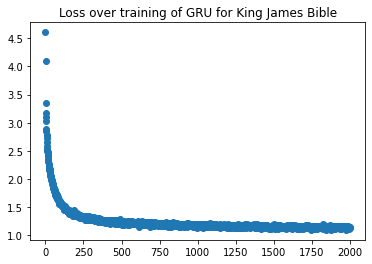

In [54]:
#Graph of Loss over t
x = range(len(all_losses))
plt.title("Loss over training of GRU for King James Bible")
plt.scatter(x, all_losses)

###Samples generated for lowercase and uppercase alphabet

In [55]:
for c in ascii_lowercase:
  print("GENERATED SAMPLE FOR: "+c)
  print(generate(decoder, c, 100, cuda=use_cuda), '\n')

for c in ascii_uppercase:
  print("GENERATED SAMPLE FOR: "+c)
  print(generate(decoder, c, 100, cuda=use_cuda), '\n')

GENERATED SAMPLE FOR: a
and of Jacob also
shall be on the man year, that the LORD took the overlai reigned of
silent for the  

GENERATED SAMPLE FOR: b
be to the
waters of Zebulun.

5:1 The soul of the tabernacle of the dead and unto them by his salvati 

GENERATED SAMPLE FOR: c
carketh thee, and not the sons of Amorecomay: 7:5 And
Simeon the trespass shall be men of the Levites 

GENERATED SAMPLE FOR: d
d a children came, and we be reachelour, and kill
the heart: and she went away, neither that sacrific 

GENERATED SAMPLE FOR: e
ed, and purple of the fourhelks, and believed in
him.

51:40 If the heave of the wisdom of the walls  

GENERATED SAMPLE FOR: f
f the end
of the enemy of the man in the flesh, neither were not fintest
to the secret of the flesh;  

GENERATED SAMPLE FOR: g
goeased age unto the other redeepron.

39:1 Therefore which much may be as from God, nor men of hosts 

GENERATED SAMPLE FOR: h
hey against the breakest them, and in the same
will let thee your lord Jeremiah 

# #4.5 Comparison between Bible vs. Shakespeare GRU
- The loss was lower when we trained the GRU using the king James bible (~1.1 for bible vs. ~1.3 for shakespeare)
- As for the realisticness of the samples, it is hard to compare the two because they have very different writing styles. However the bible GRU did learn how to use numbers (ie. 2:32) and does seem to generate realistic names of charecters in the bible. The shakespeare one, similarly, generates realisticly formated diaglouge and also generates realistic charecter names at times.